# 8 拡散モデルの理論

## 8.1 VAEから拡散モデル

本ステップで導入する「拡散モデル」：DDPM（Denoising Diffusion Probabilistic Model）

- Denoising(デノイジング)：ノイズの除去
- Diffusion(拡散)：物質が均一に広がる現象
- Probabilistic(確率的)：確率を用いた手法

### 8.1.1 VAEの復習

VAE(Variational AutoEncoder);潜在変数のあるモデル  
データ生成は，潜在変数を固定の正規分布よりサンプリングし，潜在変数から観測変数への変換をニューラルネットワークで行う  
そしてもう一つの別のニューラルネットワークを使い，観測変数から潜在変数への変換を行う

$p_\theta(\bm{x}|\bm{z})$：潜在変数$\bm{z}$から観測変数$\bm{x}$への確率分布  
$q_\phi(\bm{z}|\bm{x})$：観測変数$\bm{x}$から潜在変数$\bm{z}$への確率分布

<img src="img/vae.png" alt="VAEのモデル図" width="500" />




### 8.1.2 潜在変数の階層化
階層型VAE：潜在変数を階層化したモデル  
マルコフ性：直前の状態のみに依存する  
→マルコフ性を仮定することでパラメータの増加を防ぐことができる  

詳細  
付録C　階層型VAEの理論と実装

### 8.1.3 拡散モデルへ

階層型VAEから拡散モデルにするために以下の2点を変更
- 観測変数と潜在変数の次元数を同じにする
- エンコーダは，固定の正規分布によるノイズを追加する

ガウスノイズ：正規分布から生成された乱数

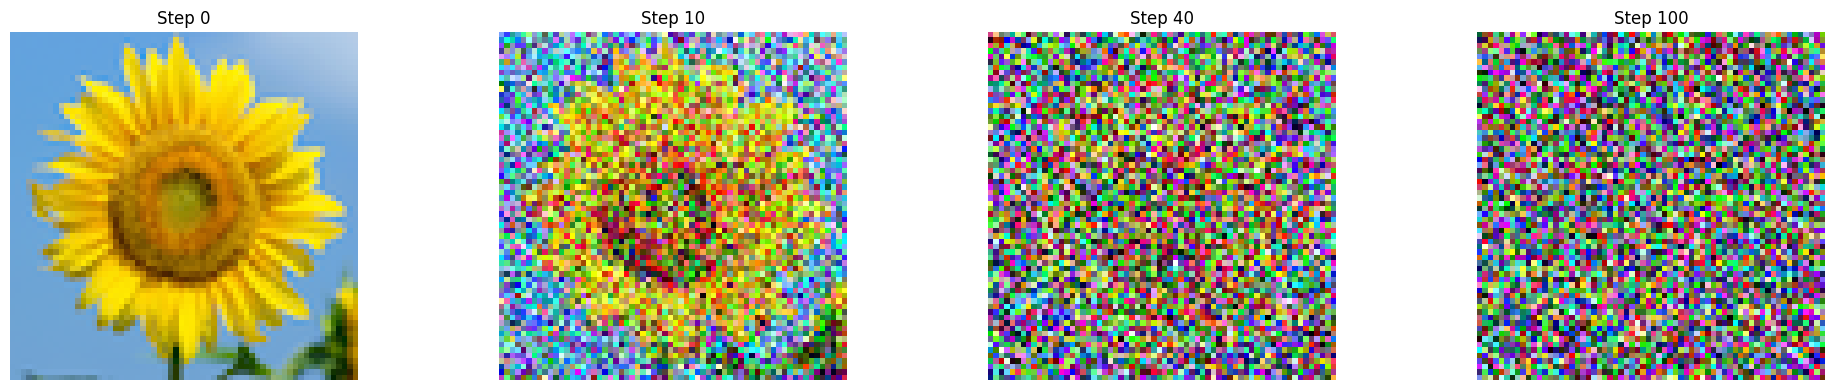

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# flower.png をカラーで読み込み，0-1に正規化
img = Image.open('img/flower.png').convert('RGB')
img = np.array(img).astype(np.float32) / 255.0

# 拡散パラメータ
beta_t = 0.01
total_steps = 100
display_steps = [0, 10, 40,100]  # 表示タイミング

# 初期画像
x_t = img.copy()
step_images = {0: x_t.copy()}

# 拡散過程
for t in range(1, total_steps + 1):
    noise = np.random.normal(0, np.sqrt(beta_t), size=x_t.shape)
    x_t = np.sqrt(1 - beta_t) * x_t + noise
    x_t = np.clip(x_t, 0, 1)
    
    if t in display_steps:
        step_images[t] = x_t.copy()

# 描画
fig, axes = plt.subplots(1, len(display_steps), figsize=(20, 4))
for ax, step in zip(axes, display_steps):
    ax.imshow(step_images[step])
    ax.set_title(f"Step {step}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## 8.2 拡散過程と逆拡散過程

- 拡散過程：ノイズを追加する処理，粒子がランダムな運動によって均一に広がる現象になぞらえて拡散過程という  
- 逆拡散過程：ノイズを除去する処理，拡散過程とは逆の方向


### 8.2.1 拡散過程

拡散過程：前時刻のデータに対してノイズを加える．  
満たすべき条件：最終時刻における$\bm{x}_T$が元データの成分が含まれない完全なノイズになること（e.g. $\mathcal{N}(\bm{x}_T; 0, \mathbf{I})$）

$$
q(\bm{x}_t|\bm{x}_{t-1}) = \mathcal{N}(\bm{x}_t; \sqrt{1-\beta_t} \bm{x}_{t-1}, \beta_t \mathbf{I})\tag{8.1}
$$

- $\beta_t$：時刻$t$におけるノイズの大きさを表すハイパーパラメータ  
- $t$：$1 \leq t \leq T$の整数

また，十分大きな$T$で$\beta_t$をある範囲に調整すれば，$\bm{x}_T$は次のような正規分布に従う：

$$
p(\bm{x}_T) \approx \mathcal{N}(\bm{x}_T; 0, \mathbf{I})
$$

式(8.1)は、平均ベクトルが $ \sqrt{1 - \beta_t} \, \bm{x}_{t-1} $、共分散行列が $ \beta_t \, \mathbf{I} $ の正規分布である．変数変換トリックを使うと次の式で表すことができる

$$
\begin{align*}
\epsilon &\sim \mathcal{N}(\epsilon ; 0, \mathbf{I})\\
\bm{x}_t &= \sqrt{1-\beta_t} \bm{x}_{t-1} + \sqrt{\beta_t} \epsilon 
\end{align*}
$$

e.g. $ \beta_t =0.01$のとき
$$
x_t = 0.995x_{t-1} + 0.1\epsilon
$$



### 8.2.2 逆拡散過程

1つのニューラルネットワークによって各時刻のノイズ除去をする

\begin{align}
\hat{\bm{x}}_{t-1} &= \text{NeuralNet}(\bm{x}_t, t; \theta) \\
 p_\theta(\bm{x}_{t-1} | \bm{x}_t) &= \mathcal{N}(\bm{x}_{t-1}; \hat{\bm{x}}_{t-1}, \mathbf{I}) 
\end{align}

## 8.3 ELBOの計算①

拡散モデルの学習はVAEと同じ流れ  
対数尤度の計算が困難なのでELBOを最適化の対象とする  

ELBO計算の改善ロードマップ　
1. サンプルサイズT　→8.3節
2. サンプルサイズ2　→8.4節
3. サンプルサイズ1　→8.5節

### 8.3.1 拡散モデルのELBO

ELBO  
$$\mathrm{ELBO}(\bm{x};\theta,\phi) = \mathbb{E}_{q_\phi(\bm{z}|\bm{x})} \left[ \log \frac{p_\theta(\bm{x}, \bm{z})}{q_\phi(\bm{z}|\bm{x})} \right]$$


以下の3点
- $\bm{x}$を$\bm{x}_0$へ変更
- $\bm{z}$を $\bm{x}_1,\bm{x}_2,...,\bm{x}_T$へ変更
- パラメータ$\phi$の消去 


$$
\mathrm{ELBO}(\bm{x}_0; \theta) = \mathbb{E}_{q(\bm{x}_1,\bm{x}_2,...,\bm{x}_T | \bm{x}_0)} \left[ \log \frac{p_\theta(\bm{x}_0, \bm{x}_1,\bm{x}_2,...,\bm{x}_T)}{q(\bm{x}_1,\bm{x}_2,...,\bm{x}_T | \bm{x}_0)} \right]
$$

数式の表記を以下のように簡略化する
$$\bm{x}_{0:T}=\bm{x}_0,\bm{x}_1,...,\bm{x}_T$$

この表記を使って書きなおすと拡散モデルのELBOは次の式で表される
$$
\mathrm{ELBO}(\bm{x}_0; \theta) = \mathbb{E}_{q(\bm{x}_{1:T} | \bm{x}_0)} \left[ \log \frac{p_\theta(\bm{x}_{0:T})}{q(\bm{x}_{1:T} | \bm{x}_0)} \right]
\tag{8.2}
$$

付録B　イェンセンの不等式

### 8.3.2 ELBOの式展開
(8.2)のlogの分子：  
乗法定理($p(\bm{x}_0 , \bm{x}_1) =p(\bm{x}_0 | \bm{x}_1) \cdot p(\bm{x}_1)$)とマルコフ性より，
$$
\begin{align*}
p_\theta(\bm{x}_{0:T}) 
&= p_\theta(\bm{x}_0, \bm{x}_1, \dots, \bm{x}_T) \\
&= p(\bm{x}_T) \cdot p_\theta(\bm{x}_{T-1} \mid \bm{x}_T) \cdot p_\theta(\bm{x}_{T-2} \mid \bm{x}_{T-1}) \cdots p_\theta(\bm{x}_0 \mid \bm{x}_1) \\
&= p(\bm{x}_T) \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)
\end{align*}
$$

(8.2)のlogの分母：  
$$
\begin{align*}
q(\bm{x}_{1:T} \mid \bm{x}_0) 
&= q(\bm{x}_1, \bm{x}_2, \dots, \bm{x}_T \mid \bm{x}_0) \\
&= q(\bm{x}_1 \mid \bm{x}_0) \cdot q(\bm{x}_2 \mid \bm{x}_1, \bm{x}_0) \cdots q(\bm{x}_T \mid \bm{x}_{T-1}, \dots, \bm{x}_0) \\
&= \prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1})
\end{align*}
$$


よって，

\begin{align*}
\mathrm{ELBO}(\bm{x}_0; \theta)
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \frac{p_\theta(\bm{x}_{0:T})}{q(\bm{x}_{1:T} \mid \bm{x}_0)} \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \left( \frac{p(\bm{x}_T) \cdot \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{\prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1})} \right) \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log p(\bm{x}_T) + \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) - \log \prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1}) \right] \\
&= \underbrace{ \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] }_{\text{学習対象の項 (depend on } \theta\text{)}} \\
&\quad + \underbrace{ \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log p(\bm{x}_T) - \log \prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1}) \right] }_{\text{定数項 (do not depend on } \theta\text{)}}
\end{align*}

目的関数
$$
\begin{align*}
J(\theta) &= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \sum_{t=1}^{T} \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] 

\end{align*}
$$

期待値をモンテカルロ法によって近似  
モンテカルロ法のサンプルサイズは1とする

\begin{align*}
\bm{x}_{1:T} &\sim q(\bm{x}_{1:T} \mid \bm{x}_0) \\
J(\theta) &= \sum_{t=1}^{T} \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)
\end{align*}

8.2.2節より再掲

\begin{align}
\hat{\bm{x}}_{t-1} &= \text{NeuralNet}(\bm{x}_t, t; \theta) \\
 p_\theta(\bm{x}_{t-1} | \bm{x}_t) &= \mathcal{N}(\bm{x}_{t-1}; \hat{\bm{x}}_{t-1}, \mathbf{I}) 
\end{align}

目的関数

$$
\begin{align*}
J(\theta) 
&= \sum_{t=1}^{T} \log p_{\theta}(\bm{x}_{t-1}|\bm{x}_{t})\\
&= \sum_{t=1}^{T} \log \mathcal{N}(\bm{x}_{t-1} ; \hat{\bm{x}}_{t-1}, \mathbf{I}) \\
&= \sum_{t=0}^{T-1} \log \mathcal{N}(\bm{x}_t ; \hat{\bm{x}}_t, \mathbf{I}) \\
&= \sum_{t=0}^{T-1} \log \left[ \frac{1}{\sqrt{(2\pi)^D \cdot |\mathbf{I}|}} \exp\left( -\frac{1}{2} (\bm{x}_t - \hat{\bm{x}}_t)^\top \mathbf{I}^{-1} (\bm{x}_t - \hat{\bm{x}}_t) \right) \right] \\
&= \sum_{t=0}^{T-1} \log \left[ \frac{1}{\sqrt{(2\pi)^D}} \exp\left( -\frac{1}{2} (\bm{x}_t - \hat{\bm{x}}_t)^\top (\bm{x}_t - \hat{\bm{x}}_t) \right) \right] \\
&= \sum_{t=0}^{T-1} \log \frac{1}{\sqrt{(2\pi)^D}} 
   + \sum_{t=0}^{T-1} \log \exp\left( -\frac{1}{2} (\bm{x}_t - \hat{\bm{x}}_t)^\top (\bm{x}_t - \hat{\bm{x}}_t) \right) \\
&= \sum_{t=0}^{T-1} \log \frac{1}{\sqrt{(2\pi)^D}} 
   - \frac{1}{2} \sum_{t=0}^{T-1} (\bm{x}_t - \hat{\bm{x}}_t)^\top (\bm{x}_t - \hat{\bm{x}}_t) \\
&= \underbrace{T \log \frac{1}{\sqrt{(2\pi)^D}}}_{\text{定数}} 
   - \frac{1}{2} \sum_{t=0}^{T-1} (\bm{x}_t - \hat{\bm{x}}_t)^\top (\bm{x}_t - \hat{\bm{x}}_t)
\end{align*}
$$


定数項を無視

$$
\begin{align*}
J(\theta) 
&\approx -\frac{1}{2} \sum_{t=0}^{T-1}(\bm{x}_t - \hat{\bm{x}}_t)^\top (\bm{x}_t - \hat{\bm{x}}_t) \\
&=  -\frac{1}{2} \sum_{t=0}^{T-1}  \left\| \bm{x}_t - \hat{\bm{x}}_t \right\|^2
\end{align*}
$$

まとめ
1. 拡散過程により$T$個のサンプリングを行い，
2. ニューラルネットワークを$T$回適用してノイズ除去を行い，
3. 各時刻の2乗誤差$\left\| \bm{x}_t - \hat{\bm{x}}_t \right\|^2$を求める


## 8.4 ELBOの計算②

2個のサンプリングデータによってELBOを近似

### 8.4.1 $q(\bm{x}_t|\bm{x}_0)$の式



$$
q(\bm{x}_t \mid \bm{x}_0) = \mathcal{N}(\bm{x}_t ; \sqrt{\bar{\alpha}_t} \bm{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
$$

$$
\begin{align*}
\alpha_t       &= 1 - \beta_t \\
\bar{\alpha}_t &= \alpha_1 \alpha_2 \cdots \alpha_t
\end{align*}
$$

### 8.4.2 ELBOの近似解


\begin{align*}
\mathrm{ELBO}(\bm{x}_0; \theta)
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \frac{p_\theta(\bm{x}_{0:T})}{q(\bm{x}_{1:T} \mid \bm{x}_0)} \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \left( \frac{p(\bm{x}_T) \cdot \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{\prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1})} \right) \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log p(\bm{x}_T) + \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) - \log \prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1}) \right] \\
&= \underbrace{ \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] }_{\text{学習対象の項 (depend on } \theta\text{)}} \\
&\quad + \underbrace{ \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log p(\bm{x}_T) - \log \prod_{t=1}^{T} q(\bm{x}_t \mid \bm{x}_{t-1}) \right] }_{\text{定数項 (do not depend on } \theta\text{)}}
\end{align*}

目的関数
$$
\begin{align*}
J(\theta) &= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log \prod_{t=1}^{T} p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \\
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \sum_{t=1}^{T} \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] 

\end{align*}
$$

ここまでは8.3節と同じ

\begin{align*}
J(\theta) 
&= \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \sum_{t=1}^{T} \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \\
&= \sum_{t=1}^{T} \mathbb{E}_{q(\bm{x}_{1:T} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \quad \text{(期待値の線形性)} \\
&= \sum_{t=1}^{T} \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \quad \text{($\bm{x}_{t-1}, \bm{x}_t$ に関する期待値)} \\

\end{align*}

期待値の線形性
$$
\begin{align*}
\mathbb{E}_{p} \left[ \sum_{i} f_i(X) \right] = \sum_{i} \mathbb{E}_{p} \left[ f_i(X) \right]
\end{align*}
$$

関連する変数の期待値
\begin{align*}
\mathbb{E}_{p(X, Y)} \left[ f(X) \right] = \mathbb{E}_{p(X)} \left[ f(X) \right]
\end{align*}

目的関数

\begin{align*}
J(\theta)
  &= \sum_{t=1}^{T} \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \tag{8.4} 
\end{align*}

T個の和として表される  
Tが多いと計算量が多くなる  
→T個の和を**一様分布**に関する期待値として表されることを利用

\begin{align*}
\mathbb{E}_{u(t)}[f(t)] 
&= \sum_{t = 1}^{T} f(t) \cdot u(t) \\
&= \sum_{t = 1}^{T} f(t) \cdot \frac{1}{T} \\
&= \frac{1}{T} \sum_{t = 1}^{T} f(t)
\end{align*}

より，

\begin{align*}
\mathbb{E}_{u(t)}[f(t)] &= \frac{1}{T} \sum_{t = 1}^{T} f(t) \\
\Rightarrow \quad \sum_{t = 1}^{T} f(t) &= T \cdot \mathbb{E}_{u(t)}[f(t)]
\end{align*}

式(8.4)より，

\begin{align*}
J(\theta)
  &= \sum_{t=1}^{T} \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \tag{8.4} \\
  &= T \cdot \mathbb{E}_{u(t)} 
      \left[ \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \right]
\end{align*}

\begin{align*}
t &\sim U\{1, T\} \\
\bm{x}_{t-1} &\sim q(\bm{x}_{t-1} \mid \bm{x}_0) \\
\bm{x}_{t} &\sim q(\bm{x}_t \mid \bm{x}_{t-1}) \\
J(\theta) &\approx T \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)
\end{align*}

\begin{align}
\hat{\bm{x}}_{t-1} &= \text{NeuralNet}(\bm{x}_t, t; \theta) \\
 p_\theta(\bm{x}_{t-1} | \bm{x}_t) &= \mathcal{N}(\bm{x}_{t-1}; \hat{\bm{x}}_{t-1}, \mathbf{I}) 
\end{align}


\begin{align*}
J(\theta) 
&\approx T \cdot \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \\
&= T \cdot \log \mathcal{N}(\bm{x}_{t-1}; \hat{\bm{x}}_{t-1}, \mathbf{I})  \\
&= T \cdot \log \left[ \frac{1}{(2\pi)^{D/2} \cdot |\mathbf{I}|^{1/2}} 
     \exp\left( -\frac{1}{2} (\bm{x}_{t-1} - \hat{\bm{x}}_{t-1})^\top \mathbf{I}^{-1} (\bm{x}_{t-1} - \hat{\bm{x}}_{t-1}) \right) \right] \\
&= T \cdot \left\{ \log \left( \frac{1}{(2\pi)^{D/2}} \right)
   - \frac{1}{2} (\bm{x}_{t-1} - \hat{\bm{x}}_{t-1})^\top (\bm{x}_{t-1} - \hat{\bm{x}}_{t-1}) \right\} \\
&= \underbrace{-\frac{TD}{2} \log(2\pi)}_{\text{定数}} 
   - \frac{T}{2} \left\| \bm{x}_{t-1} - \hat{\bm{x}}_{t-1} \right\|^2
\end{align*}

最終的な形：
$$
J(\theta) =- \frac{T}{2}  \left\| \bm{x}_{t-1} - \hat{\bm{x}}_{t-1} \right\|^2
$$

まとめ
1. 一様分布$U\{1,T\}$から時刻$t$をサンプリングする
2. $q(\bm{x}_{t-1}|\bm{x}_0)$から$\bm{x}_{t-1}$をサンプリングし，次に$q(\bm{x}_t|\bm{x}_{t-1})$から$\bm{x}_{t-1}$をサンプリングする
3. ニューラルネットワークに$\bm{x}_{t}$を入力して$\hat{\bm{x}}_{t-1}$を出力する
4. 2乗誤差$\left\| \bm{x}_t - \hat{\bm{x}}_t \right\|^2$を求める


### 8.4.3 $q(\bm{x}_t|\bm{x}_0)$の導出


ガウスノイズの性質：ガウスノイズの和もまたガウスノイズになる

$$
\begin{align*}
x &\sim \mathcal{N}(\mu_x, \sigma_x^2) \\
y &\sim \mathcal{N}(\mu_y, \sigma_y^2) \\
\end{align*}
$$

$x,y$は独立

$$
\begin{align*}
z &= x + y \\
\Rightarrow z &\sim \mathcal{N}(\mu_x + \mu_y,\; \sigma_x^2 + \sigma_y^2)
\end{align*}
$$

ガウスノイズの性質を拡散過程に応用する

$$
q(\bm{x}_t|\bm{x}_{t-1}) = \mathcal{N}(\bm{x}_t; \sqrt{1-\beta_t} \bm{x}_{t-1}, \beta_t \mathbf{I})\tag{8.1}
$$

$\alpha_t$を用いる

$$
q(\bm{x}_t \mid \bm{x}_0) = \mathcal{N}(\bm{x}_t ; \sqrt{\alpha_t} \bm{x}_{t-1}, (1 - \alpha_t) \mathbf{I})
$$

$$
\alpha_t = 1 - \beta_t
$$

変数変換トリックを使うと

$$
\begin{align*}
\epsilon_t &\sim \mathcal{N}(0, \mathbf{I}) \\
\bm{x}_t &= \sqrt{\alpha_t} \bm{x}_{t-1} + \sqrt{1 - \alpha_t} \, \epsilon_t \tag{8.5}
\end{align*}
$$

$t$を$t-1$にする


$$
\begin{align*}
\epsilon_{t-1} &\sim \mathcal{N}(0, \mathbf{I}) \\
\bm{x}_{t-1} &= \sqrt{\alpha_{t-1}} \bm{x}_{t-2} + \sqrt{1 - \alpha_{t-1}} \, \epsilon_{t-1}　\tag{8.6}
\end{align*}
$$

(8.5),(8.6)より
$$
\begin{align*}
\bm{x}_t 
&= \sqrt{\alpha_t} \bm{x}_{t-1} + \sqrt{1 - \alpha_t} \, \epsilon_t  \\
&= \sqrt{\alpha_t} \left( \sqrt{\alpha_{t-1}} \bm{x}_{t-2} + \sqrt{1 - \alpha_{t-1}} \, \epsilon_{t-1} \right) + \sqrt{1 - \alpha_t} \, \epsilon_t \\
&= \sqrt{\alpha_t \alpha_{t-1}} \bm{x}_{t-2} 
  + \sqrt{\alpha_t (1 - \alpha_{t-1})} \, \epsilon_{t-1} 
  + \sqrt{1 - \alpha_t} \, \epsilon_t　　　\tag{8.7}
\end{align*}
$$

$\sqrt{\alpha_t (1 - \alpha_{t-1})} \, \epsilon_{t-1} + \sqrt{1 - \alpha_t} \, \epsilon_t　$
は，$\mathcal{N}(0,\; [1 - \alpha_t \alpha_{t-1}] \, \mathbf{I})$に従うので

$$
\begin{align*}
\epsilon & \sim \mathcal{N}(0,\mathbf{I})\\
\bm{x}_t  
&= \sqrt{\alpha_t \alpha_{t-1}} \, \bm{x}_{t-2} 
  + \sqrt{1 - \alpha_t \alpha_{t-1}} \, \epsilon\tag{8.8}

\end{align*}
$$

式(8.8)の$\bm{x_{t-2}}$...に対しても同じ式変形を続ける
$$
\begin{align*}
\bm{x}_t 
&= \sqrt{\alpha_t \alpha_{t-1} \alpha_{t-2}} \bm{x}_{t-3} \\
&\quad + \sqrt{\alpha_t \alpha_{t-1} (1 - \alpha_{t-2})} \, \epsilon_{t-2} 
     + \sqrt{\alpha_t (1 - \alpha_{t-1})} \, \epsilon_{t-1} 
     + \sqrt{1 - \alpha_t} \, \epsilon_t \\
&= \sqrt{\alpha_t \alpha_{t-1} \alpha_{t-2}} \bm{x}_{t-3} 
  + \sqrt{1 - \alpha_t \alpha_{t-1} \alpha_{t-2}} \, \epsilon \quad (\epsilon \sim \mathcal{N}(0, \mathbf{I})) \\[1em]

&\longrightarrow \quad \bm{x}_t = \sqrt{\bar{\alpha}_t} \bm{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon
\end{align*}
$$


$$
q(\bm{x}_t \mid \bm{x}_0) = \mathcal{N}(\bm{x}_t ; \sqrt{\bar{\alpha}_t} \bm{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
$$

$$
\begin{align*}
\alpha_t       &= 1 - \beta_t \\
\bar{\alpha}_t &= \alpha_1 \alpha_2 \cdots \alpha_t
\end{align*}
$$

## 8.5 ELBOの計算③

1個のサンプリングデータによってELBOを近似

### 8.5.1 $q(\bm{x}_{t-1}|\bm{x}_t,\bm{x}_0)$の式

$$
q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
= \mathcal{N} \left( \bm{x}_{t-1};\; \bm{\mu}_q(\bm{x}_t, \bm{x}_0),\; \bm{\sigma}_q^2(t) \mathbf{I} \right)
$$


$$
\begin{align*}
\alpha_t                   &= 1 - \beta_t \\
\bar{\alpha}_t             &= \alpha_1 \alpha_2 \cdots \alpha_t \\[1em]

\bm{\mu}_q(\bm{x}_t, \bm{x}_0) 
                           &= \frac{
                             \sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1}) \bm{x}_t 
                             + \sqrt{\bar{\alpha}_{t-1}} (1 - \alpha_t) \bm{x}_0
                             }{
                             1 - \bar{\alpha}_t
                             } \\[1em]

\bm{\sigma}_q^2(t)         
                           &= \frac{
                             (1 - \alpha_t)(1 - \bar{\alpha}_{t-1})
                             }{
                             1 - \bar{\alpha}_t
                             }
\end{align*}
$$


### 8.5.2 ELBOの近似解

\begin{align*}
J(\theta)
  &= \sum_{t=1}^{T} \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] \tag{8.4} \\
  &= T \cdot \mathbb{E}_{u(t)} 
      \left[ 
        \underbrace{ \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_{t} \mid \bm{x}_0)} \left[ \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) \right] }_{J_0}
      \right]
\end{align*}

定数項を追加



$$
\begin{align*}
\arg\max_\theta J(\theta)
&= \arg\max_\theta \, \mathbb{E}_{u(t)} 
   \left[
     J_0
     - 
     \underbrace{
       \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_t \mid \bm{x}_0)} 
       \left[ \log q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0) \right]
     }_{\text{定数}}
   \right] \\[0.5em]
&= \arg\max_\theta \, 
   \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_t \mid \bm{x}_0)} 
   \left[ 
     \log p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) 
     - \log q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0) 
   \right] \\[0.5em]
&= \arg\max_\theta \, 
\underbrace{
\mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_t \mid \bm{x}_0)} 
\left[
  \log 
  \frac{p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)}
\right]
}_{J_1}
\end{align*}
$$

$$
J(\theta) = T 
\mathbb{E}_{u(t)} 
   \left[
     J_1
   \right] \\[0.5em]
$$

$J_1$の式変形

$$
\begin{align*}
J_1 
&= \mathbb{E}_{q(\bm{x}_{t-1}, \bm{x}_t \mid \bm{x}_0)} 
\left[
  \log 
  \frac{p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)}
\right] \\[1em]

&= \iint q(\bm{x}_{t-1}, \bm{x}_t \mid \bm{x}_0) 
\log 
\frac{p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)} 
\, d\bm{x}_{t-1} \, d\bm{x}_t \\[1em]

&= \int q(\bm{x}_t \mid \bm{x}_0) \left[ 
\int q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0) 
\log 
\frac{p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)}{q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)} 
\, d\bm{x}_{t-1} 
\right] d\bm{x}_t \\[1em]

&= - \mathbb{E}_{q(\bm{x}_t \mid \bm{x}_0)} 
\left[
  D_{KL} \left( 
    q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0) 
    \,\|\, 
    p_\theta(\bm{x}_{t-1} \mid \bm{x}_t) 
  \right)
\right]
\end{align*}
$$

\begin{align}
\hat{\bm{x}}_{t-1} &= \text{NeuralNet}(\bm{x}_t, t; \theta) \\
 p_\theta(\bm{x}_{t-1} | \bm{x}_t) &= \mathcal{N}(\bm{x}_{t-1}; \hat{\bm{x}}_{t-1}, \bm{\sigma}_q^2(t) \mathbf{I}) \\
 &=\mathcal{N} \left( \bm{x}_{t-1};\; \bm{\mu}_\theta(\bm{x}_t, t),\; \bm{\sigma}_q^2(t) \mathbf{I} \right)
\end{align}

KLダイバージェンス

$$
D_{\mathrm{KL}} \left( 
  q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
  \;\|\;
  p_\theta(\bm{x}_{t-1} \mid \bm{x}_t)
\right)
= \frac{1}{2 \bm{\sigma}_q^2(t)} 
  \left\| 
    \bm{\mu}_\theta(\bm{x}_t, t) - \bm{\mu}_q(\bm{x}_t, \bm{x}_0)
  \right\|^2
$$

目的関数

$$
J(\theta) = - T 
\mathbb{E}_{u(t)} 
   \left[
     \mathbb{E}_{q(\bm{x}_t \mid \bm{x}_0)} 
     \left[
     \frac{1}{2 \bm{\sigma}_q^2(t)} 
  \left\| 
    \bm{\mu}_\theta(\bm{x}_t, t) - \bm{\mu}_q(\bm{x}_t, \bm{x}_0)
  \right\|^2
  \right]

   \right] \\[0.5em]
$$

損失関数

$$
\mathbf{LOSS}(\bm{x}_0;\theta) = 
\mathbb{E}_{u(t)} 
   \left[
     \mathbb{E}_{q(\bm{x}_t \mid \bm{x}_0)} 
     \left[
     \frac{1}{ \bm{\sigma}_q^2(t)} 
  \left\| 
    \bm{\mu}_\theta(\bm{x}_t, t) - \bm{\mu}_q(\bm{x}_t, \bm{x}_0)
  \right\|^2
  \right]

   \right] \\[0.5em]
$$

サンプルサイズ1のモンテカルロ法によって，

$$
\begin{align*}
t & \sim U\{1,T\}\\
\bm{x}_t & \sim q(\bm{x}_t,\bm{x}_0)\\
\mathbf{LOSS}(\bm{x}_0;\theta) &= 
\frac{1}{ \bm{\sigma}_q^2(t)} 
  \left\| 
    \bm{\mu}_\theta(\bm{x}_t, t) - \bm{\mu}_q(\bm{x}_t, \bm{x}_0)
  \right\|^2
\end{align*}
$$

### 8.5.3 $q(\bm{x}_{t-1}|\bm{x}_t,\bm{x}_0)$の導出

ベイズの定理より，
$$
q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
= \frac{
  q(\bm{x}_t \mid \bm{x}_{t-1}, \bm{x}_0) \cdot q(\bm{x}_{t-1} \mid \bm{x}_0)
}{
  q(\bm{x}_t \mid \bm{x}_0)
}
$$

マルコフ性により、$q(\bm{x}_t \mid \bm{x}_{t-1}, \bm{x}_0) = q(\bm{x}_t \mid \bm{x}_{t-1})$が成り立つので


$$
q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
= \frac{
  q(\bm{x}_t \mid \bm{x}_{t-1}) \cdot q(\bm{x}_{t-1} \mid \bm{x}_0)
}{
  q(\bm{x}_t \mid \bm{x}_0)
}
$$

これまでに得た式

$$
\begin{align*}
q(\bm{x}_t \mid \bm{x}_{t-1}) &= \mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\alpha_t} \bm{x}_{t-1},\;
  (1 - \alpha_t) \mathbf{I}
\right) \\[0.5em]
q(\bm{x}_t \mid \bm{x}_0)      &= \mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\bar{\alpha}_t} \bm{x}_0,\;
  (1 - \bar{\alpha}_t) \mathbf{I}
\right)
\end{align*}
$$

$$
\begin{align*}
q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
&= \frac{
  q(\bm{x}_t \mid \bm{x}_{t-1}) \cdot q(\bm{x}_{t-1} \mid \bm{x}_0)
}{
  q(\bm{x}_t \mid \bm{x}_0)
} \\
&= \frac{
  \mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\alpha_t} \bm{x}_{t-1},\;
  (1 - \alpha_t) \mathbf{I}
\right) 
 \cdot \mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\bar{\alpha}_t} \bm{x}_0,\;
  (1 - \bar{\alpha}_t) \mathbf{I}
\right)
}{
 \mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\bar{\alpha}_t} \bm{x}_0,\;
  (1 - \bar{\alpha}_t) \mathbf{I}
\right)
}

\end{align*}
$$


3つの正規分布の積と除算によって表される．正規分布の指数部分に注目

$$
\mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\alpha_t} \bm{x}_{t-1},\;
  (1 - \alpha_t) \mathbf{I}
\right)
\propto 
\exp\left[
  -\frac{1}{2}
  (\bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1})^\top
  (1 - \alpha_t)^{-1} \mathbf{I}^{-1}
  (\bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1})
\right]
$$

$$
\begin{align*}
\mathcal{N}\left(
  \bm{x}_t;\;
  \sqrt{\alpha_t} \bm{x}_{t-1},\;
  (1 - \alpha_t) \mathbf{I}
\right)
&\propto 
\exp\left[
  -\frac{1}{2}
  (\bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1})^\top
  (1 - \alpha_t)^{-1} \mathbf{I}^{-1}
  (\bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1})
\right] \\[0.5em]
&=
\exp\left[
  -\frac{1}{2} \cdot
  \left(
    \frac{\left\| \bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1} \right\|^2}{1 - \alpha_t}
    
  \right)
\right]
\end{align*}
$$

$$
\begin{align*}
\mathcal{N}(\bm{x}_t;\; \sqrt{\alpha_t} \bm{x}_{t-1},\; (1 - \alpha_t) \mathbf{I})
&\propto \exp\left[
  -\frac{1}{2(1 - \alpha_t)} \left\| \bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1} \right\|^2
\right] \\[0.5em]

\mathcal{N}(\bm{x}_{t-1};\; \sqrt{\bar{\alpha}_{t-1}} \bm{x}_0,\; (1 - \bar{\alpha}_{t-1}) \mathbf{I})
&\propto \exp\left[
  -\frac{1}{2(1 - \bar{\alpha}_{t-1})} \left\| \bm{x}_{t-1} - \sqrt{\bar{\alpha}_{t-1}} \bm{x}_0 \right\|^2
\right] \\[0.5em]

\mathcal{N}(\bm{x}_t;\; \sqrt{\bar{\alpha}_t} \bm{x}_0,\; (1 - \bar{\alpha}_t) \mathbf{I})
&\propto \exp\left[
  -\frac{1}{2(1 - \bar{\alpha}_t)} \left\| \bm{x}_t - \sqrt{\bar{\alpha}_t} \bm{x}_0 \right\|^2
\right]
\end{align*}
$$

<img src="img/code1.jpg" alt="疑似コード" width="600" />

$$
\begin{align*}
q(\bm{x}_{t-1} \mid \bm{x}_t, \bm{x}_0)
&\propto \exp\left[
  -\frac{1}{2(1 - \alpha_t)} \left\| \bm{x}_t - \sqrt{\alpha_t} \bm{x}_{t-1} \right\|^2
  -\frac{1}{2(1 - \bar{\alpha}_{t-1})} \left\| \bm{x}_{t-1} - \sqrt{\bar{\alpha}_{t-1}} \bm{x}_0 \right\|^2
  +\frac{1}{2(1 - \bar{\alpha}_t)} \left\| \bm{x}_t - \sqrt{\bar{\alpha}_t} \bm{x}_0 \right\|^2
\right]
\end{align*}
$$

<img src="img/code2.jpg" alt="疑似コード" width="600" />


<img src="img/8_5_3.JPG" alt="8_5_3" width="1000" />

上の式を
$$
\exp
  
  \left( -\frac{1}{2} \cdot
    \frac{\left\| \bm{x}_{t-1} - \bm{\mu}_q(\bm{x}_{t-1},\bm{x}_0) \right\|^2}{\sigma^2_q(t)}
    
  \right)

$$

という式に変形する

<img src="img/code3.jpg" alt="疑似コード" width="600" />

$$
\begin{align*}
\sigma^2_q(t)
&= 1/
    \left( \frac{\alpha_t}{1-\alpha_t}+ \frac{1}{1-\bar{\alpha}_{t-1}}\right)\\
&= \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{(1-\bar{\alpha}_{t-1})\alpha_t +1-\alpha_t}\\
&= \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}}
\end{align*}
$$


$$
\begin{align*}
\bm{\mu}_q(\bm{x}_t, \bm{x}_0)
&= \left(  \frac{\sqrt{\alpha_t}}{1-\alpha_t} \bm{x}_t +\frac{\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}} \bm{x}_0  \right) / 
\left(
 \frac{\alpha_t}{1-\alpha_t}+ \frac{1}{1-\bar{\alpha}_{t-1}}
\right) \\[0.5em]

&= \left(  \frac{\sqrt{\alpha_t}}{1-\alpha_t} \bm{x}_t +\frac{\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}} \bm{x}_0  \right) / 
\left(
 \frac{1-\bar{\alpha}_{t-1}}{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}
\right) \\[0.5em]

&= \frac{
\sqrt{ \alpha_t }(1 - \bar{\alpha}_{t-1}) \bm{x}_t 
  +  \sqrt{\bar{\alpha}_{t-1}} (1 - \alpha_t) \bm{x}_0
}{
  1 - \bar{\alpha}_t
}
\end{align*}
$$

## 8.6 拡散モデルの学習


### 8.6.1 ニューラルネットワークは何を予測するか？

疑似コード

<img src="code1.jpg" alt="疑似コード" width="600
" />

### 8.6.2 元データを復元するニューラルネットワーク

KLダイバージェンスが損失関数となるので，損失関数は$\hat{\bm{x}}_\theta(\bm{x}_t,t),\bm{x}_0$の2乗誤差として表される

### 8.6.3 ノイズを予測するニューラルネットワーク

教科書，省略された式変形

<img src="8_6_3.JPG" alt="8_6_3" width="1000
" />

疑似コード

<img src="code2.jpg" alt="疑似コード" width="600
" />

### 8.6.4 新しいデータのサンプリング

疑似コード

<img src="code3.jpg" alt="疑似コード" width="600
" />